In [5]:
!pip3 install transformers
!pip3 install nltk
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import transformers
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [7]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm
from matplotlib._path import (affine_transform, count_bboxes_overlapping_bbox,
     update_path_extents)

In [8]:
dataset=pd.read_csv('/content/drive/My Drive/dataset.csv')
dataset.dropna(inplace = True)
df = dataset
dataset

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [9]:
print("number of tweets belonging to classes 0,1 and 2")
dataset.groupby('class')['id'].nunique()


number of tweets belonging to classes 0,1 and 2


class
0     1430
1    19190
2     4163
Name: id, dtype: int64

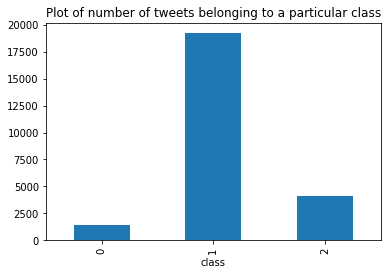

In [10]:
dataset.groupby('class')['id'].nunique().plot(kind='bar',title='Plot of number of tweets belonging to a particular class')

# **Data Cleaning**

In [11]:
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words= set(stopwords.words('english'))

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    tweet = word_tokenize(tweet)
    return_tweet=[]
    for word in tweet:
        if word not in stop_words:
            return_tweet.append(word)
    return return_tweet
dataset["tweet"]=dataset["tweet"].apply(clean_tweet)


# **Word2Vec model to get the word embedings.**

In [16]:
model = Word2Vec(dataset["tweet"].values, size=50, window=5, min_count=1, workers=4)

In [17]:
def get_features(tweet):
    features=[]
    for word in tweet:
        features.append(model.wv[word])
    return np.mean(features,0)

In [18]:
dataset["features"]=dataset["tweet"].apply(get_features)

In [19]:
data=[]
for i in dataset["features"].values:
    temp=[]
    for j in i:
        temp.append(j)
    data.append(temp)
data=np.array(data)

In [20]:
from sklearn.preprocessing import label_binarize

Y = label_binarize(dataset["class"].values, classes=[0, 1, 2])
n_classes = Y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [21]:
print(X_train)
print(y_train)

[[-0.2618981  -0.91191065  0.16393313 ... -1.0458531   0.1175053
  -0.6806985 ]
 [-0.30419624 -1.0619016   0.2034573  ... -1.246319    0.12054849
  -0.8084273 ]
 [-0.26861772 -0.8904835   0.17159379 ... -1.0378503   0.12913723
  -0.6972075 ]
 ...
 [-0.15685008 -0.6682951   0.07600575 ... -0.85604876  0.12419172
  -0.4821922 ]
 [-0.20982085 -0.7158232   0.12269703 ... -0.8366621   0.09397312
  -0.53471065]
 [-0.38170856 -1.2703182   0.25691336 ... -1.4234021   0.18803905
  -0.99437493]]
[[1 0 0]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


# **LOGISTIC REGRESSION MODEL**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

F1 Score:  0.8400412796697627
Precision Score:  0.8599197126558208
Recall Score:  0.8210611256808553
Accuracy:  0.8204559209199113


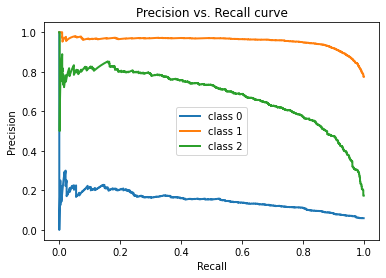

In [23]:
lr_clf = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'))
lr_clf.fit(X_train,y_train)
y_pred = lr_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", lr_clf.score(X_test,y_test))

y_score = lr_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "best")
plt.title("Precision vs. Recall curve")
plt.show()

# ***SVM MODEL***

F1 Score:  0.8023024594453164
Precision Score:  0.8336233144845585
Recall Score:  0.7732499495662699
Accuracy:  0.7732499495662699


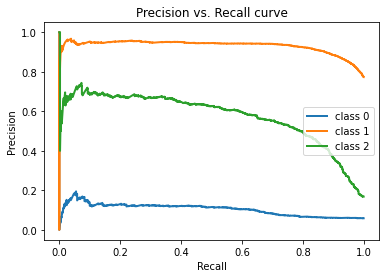

In [24]:
svm_clf = OneVsRestClassifier(svm.SVC(gamma='scale', probability=True))
svm_clf.fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)
f = f1_score(y_test, y_pred, average='micro')
print("F1 Score: ", f)
p = precision_score(y_test, y_pred, average='micro')
print("Precision Score: ", p)
r = recall_score(y_test, y_pred, average='micro')
print("Recall Score: ", r)
print("Accuracy: ", svm_clf.score(X_test,y_test))

y_score = svm_clf.predict_proba(X_test)
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "center right")
plt.title("Precision vs. Recall curve")
plt.show()

## BERT + CNN


### Data Cleaning for BERT

In [25]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights = 'bert-base-uncased'

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [28]:
max_seq = 27
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df["tweet"].values
    ]
def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])
def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)
def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [27]:
max = 0
for i in dataset["tweet"]:
  if len(i) > max:
    max = len(i)
print(max)

31


In [29]:
for i in range(0,len(dataset["tweet"])):
  dataset["tweet"][i] = " ".join(dataset["tweet"][i])

In [30]:
dataset["tweet"]

0        rt mayasolovely woman complain cleaning house ...
1        rt mleew boy dats cold tyga dwn bad cuffin dat...
2        rt urkindofbrand dawg rt sbaby life ever fuck ...
3              rt c g anderson viva based look like tranny
4        rt shenikaroberts shit hear might true might f...
                               ...                        
24778    muthaf lie lifeasking pearls corey emanuel rig...
24779      gone broke wrong heart baby drove redneck crazy
24780    young buck wan na eat dat nigguh like aint fuc...
24781                    youu got wild bitches tellin lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 24783, dtype: object

In [31]:
indices = tokenize_and_pad_text(dataset, max_seq)

[no,_] = list(indices.shape)

In [32]:
stepSize = 32
X = np.empty([0,max_seq,768])

for i in range(0,no,stepSize):
  if no - i <= stepSize:
    n = no
  else:
    n = i+stepSize
  with torch.no_grad():
    x = bert_model(indices[i:n,:])[0].detach().numpy()
  X = np.vstack([X,x])

In [33]:
label_col = ["class"]
Y = targets_to_tensor(dataset,label_col)

In [34]:
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size=0.2,random_state=42)
x_train = torch.tensor(x_train,dtype=torch.float32)
x_val = torch.tensor(x_val,dtype=torch.float32)

In [35]:
loss_func = nn.CrossEntropyLoss()

In [36]:
class HTSPC_CNN(nn.Module):
    def __init__(self,embed_num,embed_dim,class_num,kernel_num,kernel_sizes,dropout,static):
        super(HTSPC_CNN, self).__init__()
        
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.emed_layer = nn.Embedding(V, D)
        
        self.conv1 = nn.ModuleList([nn.Conv2d(1,Co,(K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        
        self.lin1 = nn.Linear(len(Ks)* Co, 3)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self,xb):
        if self.static:
            x = Variable(xb)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.conv1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.lin1(x)
        return x

In [37]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    yb = yb.squeeze_()
    # print(model(xb).squeeze_())
    # print(yb)  
    loss = loss_func(model(xb.float()), yb.long())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [38]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)


In [39]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [40]:
bs = 128
epochs = 50
learning_rate = 0.0001

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val  , y_val  )

embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]

print(class_num)

kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

train_dl, valid_dl = get_data(train_dataset, valid_dataset, bs)
model = HTSPC_CNN(embed_num,embed_dim,class_num,kernel_num,kernel_sizes,dropout,static)

opt = torch.optim.Adam(model.parameters(), lr = learning_rate)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

1
0 0.6177881338109599
1 0.5606296031025838
2 0.5015914744551152
3 0.4595446059341654
4 0.43343128126572283
5 0.41492678283057866
6 0.39971939215670677
7 0.38703847130760927
8 0.37918721081714174
9 0.37224167034057015
10 0.3636209831793077
11 0.3578376648182924
12 0.3555257002360306
13 0.3503401718397931
14 0.34641668078746435
15 0.343179079116485
16 0.34052521378156614
17 0.33983539230933657
18 0.33501077363249127
19 0.3339723445623903
20 0.33050786896665324
21 0.3299489816981793
22 0.3288372553462628
23 0.32562624937119156
24 0.3236100990607033
25 0.32440494844719653
26 0.32310842105054266
27 0.3180272705057876
28 0.32168451011697924
29 0.3187376021443054
30 0.3179127459435158
31 0.3176178543863937
32 0.3152233020887034
33 0.3158329610763742
34 0.3138306505868385
35 0.3135972200429365
36 0.3124742731797688
37 0.31021642889350276
38 0.3112130697718161
39 0.30892571614518244
40 0.3088656943009605
41 0.309112524974844
42 0.3076518483434398
43 0.30769370224522996
44 0.3101386578965144
45

In [41]:
_,preds = torch.max(model(x_val),1)

In [42]:
print(accuracy_score(preds.detach().numpy(),y_val.detach().numpy()))

0.8850110954206173


In [47]:
f = f1_score(preds.detach().numpy(),y_val.detach().numpy(), average='weighted')
print("F1 Score: ", f)
p = precision_score(preds.detach().numpy(),y_val.detach().numpy(), average='weighted')
print("Precision Score: ", p)
r = recall_score(preds.detach().numpy(),y_val.detach().numpy(), average='micro')
print("Recall Score: ", r)

F1 Score:  0.9090087527856712
Precision Score:  0.9373082700909072
Recall Score:  0.8850110954206173
